In [1]:
import cv2
import mediapipe as mp
import urllib.request as urlreq
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Ellipse
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [2]:
def readtps(input):
    """
    Function to read a .TPS file
    Args:
        input (str): path to the .TPS file
    Returns:
        lm (str list): info extracted from 'LM=' field
        im (str list): info extracted from 'IMAGE=' field
        id (str list): info extracted from 'ID=' filed
        coords: returns a 3D numpy array if all the individuals have same
                number of landmarks, otherwise returns a list containing 2d
                matrices of landmarks
    """

    # open the file
    tps_file = open(input, 'r')  # 'r' = read
    tps = tps_file.read().splitlines()  # read as lines and split by new lines
    tps_file.close()

    # initiate lists to take fields of "LM=","IMAGE=", "ID=" and the coords
    lm, im, ID, coords_array = [], [], [], []

    # looping thru the lines
    for i, ln in enumerate(tps):

        # Each individual starts with "LM="
        if ln.startswith("LM"):
            # number of landmarks of this ind
            lm_num = int(ln.split('=')[1])
            # fill the info to the list for all inds
            lm.append(lm_num)
            # initiate a list to take 2d coordinates
            coords_mat = []

            # fill the coords list by reading next lm_num of lines
            for j in range(i + 1, i + 1 + lm_num):
                coords_mat.append(tps[j].split(' '))  # split lines into values

            # change the list into a numpy matrix storing float vals
            coords_mat = np.array(coords_mat, dtype=float)
            # fill the ind 2d matrix into the 3D coords array of all inds
            coords_array.append(coords_mat)
            # coords_array.append(coords_mat)

        # Get info of IMAGE= and ID= fields
        if ln.startswith("IMAGE"):
            im.append(ln.split('=')[1])

        if ln.startswith("ID"):
            ID.append(ln.split('=')[1])

    # check if all inds contains same number of landmarks
    all_lm_same = all(x == lm[0] for x in lm)
    # if all same change the list into a 3d numpy array
    if all_lm_same:
        coords_array = np.dstack(coords_array)

    # return results in dictionary form
    return {'lm': lm, 'im': im, 'id': ID, 'coords': coords_array}

In [3]:
def LBF_model(image, prepared = False):
    if not prepared:
        # save face detection algorithm's name as haarcascade
        haarcascade = "haarcascade_frontalface_alt2.xml"

        # save facial landmark detection model's name as LBFmodel
        LBFmodel = "lbfmodel.yaml"

        if (haarcascade not in os.listdir(os.curdir)):
            haarcascade_url = "https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_alt2.xml"
            urlreq.urlretrieve(haarcascade_url, haarcascade)

        if (LBFmodel not in os.listdir(os.curdir)):
            LBFmodel_url = "https://github.com/kurnianggoro/GSOC2017/raw/master/data/lbfmodel.yaml"
            urlreq.urlretrieve(LBFmodel_url, LBFmodel)

        # create an instance of the Face Detection Cascade Classifier
        detector = cv2.CascadeClassifier(haarcascade)
        # create an instance of the Facial landmark Detector with the model
        landmark_detector = cv2.face.createFacemarkLBF()
        landmark_detector.loadModel(LBFmodel)
    
    image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Detect faces using the haarcascade classifier on the "grayscale image"
    faces = detector.detectMultiScale(image_gray)

    # Detect landmarks on "image_gray"
    _, landmarks = landmark_detector.fit(image_gray, faces)
    landmarks = landmarks[0][0,:,:]
    
    # Returns coordinates as float from 0 to 1
    landmarks = np.divide(landmarks, (image.shape[1], image.shape[0]))

    return landmarks

In [4]:
def MediaPipe_model(image):
    landmarks = np.empty((478, 2))
    mp_face_mesh = mp.solutions.face_mesh

    with mp_face_mesh.FaceMesh(
        static_image_mode=True,
        max_num_faces=1,
        refine_landmarks=True,    # Zpřesnění kolem očí a pusy!!
        min_detection_confidence=0.5) as face_mesh:

        # To improve performance
        image.flags.writeable = False

        # Detect the face landmarks
        results = face_mesh.process(image)

        # To improve performance
        #image.flags.writeable = True

    if len(results.multi_face_landmarks) == 1:
        for i, l_mark in enumerate(results.multi_face_landmarks[0].landmark):
                landmarks[i,:] = l_mark.x, l_mark.y
    
    else:
        print("Single face not detected! Only one face per picture for landmarking.")
    
    return landmarks

In [5]:
def display_landmarks(landmarks, img, pixel_scale = False, origin = None, errors = None):
    
    x_coor = landmarks[:,0]
    y_coor = landmarks[:,1]
    
    if not pixel_scale:
        x_coor = np.multiply(x_coor, img.shape[1])
        y_coor = np.multiply(y_coor, img.shape[0])
        
    if not origin == 'upper_left':
        y_coor = img.shape[0] - y_coor
    
    fig, ax = plt.subplots(1, figsize = (10,10))
    ax.imshow(image)
    #ax.axis('off')

    for i, (x, y) in enumerate(zip(x_coor, y_coor)):
        circ1 = Circle((x,y), 2, color='white', fill = False)
        ax.add_patch(circ1)
        
        if errors is None:
            pass
        else:
            err_x = errors[i,0] * image.shape[1]
            err_y = errors[i,1] * image.shape[0]
            circ2 = Ellipse((x,y), err_x, err_y, color = 'blue', fill = False)
            ax.add_patch(circ2)

    plt.show()

In [6]:
## pixel analysis - hair edge
def hair_edge(image, middle_landmarks):
    forehead = image[0:min(middle_landmarks[:,1]), middle_landmarks[0,0]:middle_landmarks[1,0],:]

    kmeans = KMeans(n_clusters = 3, n_init = 10).fit(forehead.reshape(-1,3))
    forehead_labels = kmeans.labels_.reshape(forehead.shape[0], forehead.shape[1])
    background_label = kmeans.cluster_centers_.mean(axis = 1).argmax()
    non_background_label = kmeans.cluster_centers_.mean(axis = 1).argmin()
    
    Y_coordinate = np.array([range(forehead.shape[0])] * forehead.shape[1]).transpose()
    forehead_labels = forehead_labels.reshape(-1,1)
    Y_coordinate = Y_coordinate.reshape(-1,1)
    
    face_pixels_idx = (forehead_labels != background_label).nonzero()[0]
    Y = Y_coordinate[face_pixels_idx]
    labels = (forehead_labels[face_pixels_idx] == non_background_label).reshape(-1,)
    log_reg = LogisticRegression()
    log_reg.fit(Y, labels)
    decision_boundary = -log_reg.intercept_/log_reg.coef_
    plt.figure(figsize = (10,10))
    plt.imshow(image)
    
    plt.plot(np.arange(image.shape[1]),np.array([decision_boundary] * image.shape[1]).reshape(-1,))
    plt.show()
    return decision_boundary

In [7]:
#Main Pipeline
# Tohle bude potřeba předěla na Dataset
# vracet bude x (oba modely), y_true a img_path (jako list)

def prepare_training_landmarks(both_models = True):
    if both_models:
        x = np.empty((0, 546 * 2))
    else:
        x = np.empty((0, 478 * 2))
    y_true = np.empty((0, 144))
    
    # some tree structure here
    groups = ['Males', 'Females']
    path = 'C:\\Users\\Zirov\\landmarks\\'
    path_list = []
    
    for group in groups:
        tps = readtps(path + group + '.TPS')
        print(group)
        
        for idx in tqdm(range(len(tps['im']))):
            true_landmarks = tps['coords'][:, :, idx]
            img_path = path + group + '\\' + tps['im'][idx]
            path_list.append(img_path)
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            true_landmarks = np.divide(true_landmarks, (image.shape[1], image.shape[0]))
           
            # flip y-axis u Petrových dat
            true_landmarks[:,1] = 1 - true_landmarks[:,1]  

            # Both models use float(0,1) for x and y axis
            # cv2 returns upper left origin by default - in this form is image processed by both models
            if both_models:
                input_landmarks = np.concatenate((LBF_model(image), MediaPipe_model(image)), axis = 0)
            else:
                input_landmarks = MediaPipe_model(image)
                
            input_landmarks = input_landmarks.reshape(1,-1)
            x = np.concatenate((x, input_landmarks), axis = 0)
            
            true_landmarks = true_landmarks.reshape(1,-1)
            y_true = np.concatenate((y_true, true_landmarks), axis = 0)
            
    return x, y_true, path_list

In [8]:
x_inp, y_inp, path_list = prepare_training_landmarks()

Males


100%|████████████████████████████████████████████████████████████████████████████████| 115/115 [03:20<00:00,  1.74s/it]


Females


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [04:24<00:00,  1.84s/it]


In [9]:
def make_landmark_crops(raw_landmarks, image, crop_size = 30):
    
    # Scaling from (0,1) to pixel scale and transposing landmarks
    landmarks = torch.mul(raw_landmarks, torch.tensor([image.shape[1], image.shape[0]]))
    landmarks = landmarks.permute(1,0)
    
    # Preparing index matrices of all crops
    crop_range = torch.arange(-crop_size // 2, crop_size // 2)
    crop_matrix = torch.stack([crop_range.tile((crop_size,1)), crop_range[:, None].tile((1,crop_size))], dim = 2)
    crop_indices = (landmarks[None, None,:,:] + crop_matrix[:,:,:,None]).type(torch.int)  # dims: x_coor, y_coor, x_y, no_landmarks

    # Cropping image around raw landmarks
    sub_image = torch.tensor(image[crop_indices[:,:,1,:], crop_indices[:,:,0,:], :])
    multicrop = sub_image.reshape(sub_image.shape[0], sub_image.shape[1], -1)
    
    return multicrop   # shape (x, y, 3 * num_landmarks)

In [10]:
class FaceDataset(Dataset):
    def __init__(self):
        self.x = torch.tensor(x_inp, dtype = torch.float)
        self.y_true = torch.tensor(y_inp, dtype = torch.float)
        self.path_list = path_list
        #self.x, self.y_true, self.path_list = prepare_training_landmarks()
        self.pretraining = True

    def __len__(self):
        return len(self.path_list)

    def __getitem__(self, idx):
        x = self.x[idx,:]
        y = self.y_true[idx,:]
        
        if not self.pretraining:
            img_path = self.path_list[idx]
            image = cv2.imread(img_path)
            raw_landmarks, _ = raw_projection(x)
            multicrop = make_landmark_crops(raw_landmarks.detach().reshape(-1,2), image)
            
        else:
            multicrop = 0
            
        return x, y, multicrop

In [13]:
class RawProjection(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        
        self.fc1 = nn.Linear(input_dim, input_dim, bias = True)
        self.fc2 = nn.Linear(input_dim, output_dim, bias = True)
        self.loss_func = nn.MSELoss()
    
    def forward(self, x, targets = None):
        x = self.fc1(x)
        output = self.fc2(x)
        
        if targets == None:
            loss = None
        else:
            loss = self.loss_func(output, targets)
        
        return output, loss
    
    @torch.no_grad()
    def generate(self, x):
        return self.fc2(self.fc1(x))

In [ ]:
class CNNFocusing(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(216, 216, 5, stride = 1, groups = 72)
        self.conv2 = nn.Conv2d(216, 72, 5, stride = 1, groups = 72)
        self.linear1 = nn.Linear(72 * 30 * 30, 288)
        self.linear2 = nn.Linear(288, 144)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = torch.flatten(x, 1) # která dimenze je landmarks a které jsou 30 x 30 - jak udělat, aby se crops nemíchaly.
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [183]:
face_dataset = FaceDataset()
face_dataloader = DataLoader(face_dataset, batch_size=50, shuffle=True)
raw_projection = RawProjection(1092, 144)
optimizer = torch.optim.Adam(raw_projection.parameters(), lr = 0.001)

In [219]:
epochs = 20
face_dataset.pretraining = True

for epoch in range(epochs):
    
    if epoch > 10:
        face_dataset.pretraining = False
        
    for iteration, batch in enumerate(face_dataloader):
        optimizer.zero_grad()
        
        inputs, targets, _ = batch
        _, loss = raw_projection(inputs, targets)

        if (iteration % 2 == 0):
            print(f'Iteration: {iteration}, current loss: {loss}.')

        loss.backward()
        optimizer.step()

Iteration: 0, current loss: 0.00015368878666777164.
Iteration: 2, current loss: 0.0001695373939583078.
Iteration: 4, current loss: 0.00015140230243559927.
Iteration: 0, current loss: 0.00016350248188246042.
Iteration: 2, current loss: 0.00017059770470950752.
Iteration: 4, current loss: 0.00014746314263902605.
Iteration: 0, current loss: 0.00018154503777623177.
Iteration: 2, current loss: 0.00012617430184036493.
Iteration: 4, current loss: 0.0001440734340576455.
Iteration: 0, current loss: 0.00017341854982078075.
Iteration: 2, current loss: 0.00015071823145262897.
Iteration: 4, current loss: 0.00015222519868984818.
Iteration: 0, current loss: 0.00017963697609957308.
Iteration: 2, current loss: 0.0001430226257070899.
Iteration: 4, current loss: 0.00014916439249645919.
Iteration: 0, current loss: 0.00015221204375848174.
Iteration: 2, current loss: 0.0001501668302807957.
Iteration: 4, current loss: 0.00013682311691809446.
Iteration: 0, current loss: 0.00016512186266481876.
Iteration: 2, cu

IndexError: index 745 is out of bounds for axis 0 with size 745

In [16]:
inputs, targets = get_batch(x_inputs, y_pred, batch_size = 150)
prediction = projector.generate(inputs)
errors = prediction - targets
std_errors = torch.std(errors, dim = 0)
std_errors = std_errors.detach().numpy().reshape(int(prediction.shape[1]/2), 2)
two_std_errors = 2 * torch.std(errors, dim = 0)
two_std_errors = two_std_errors.detach().numpy().reshape(int(prediction.shape[1]/2), 2)
three_std_errors = 3 * torch.std(errors, dim = 0)
three_std_errors = three_std_errors.detach().numpy().reshape(int(prediction.shape[1]/2), 2)
#pixel_errors = np.concatenate((two_std_errors[:,:1] * image.shape[1], two_std_errors[:,1:] * image.shape[0]), axis = 1)
#pixel_errors

In [165]:
def show_some_results(idx):   
    # some tree structure here
    groups = ['Males', 'Females']
    path = 'C:\\Users\\Zirov\\landmarks\\'
    tps = readtps(path + groups[0] + '.TPS')

    true_landmarks = tps['coords'][:, :, idx]
    img_path = path + groups[0] + '\\' + tps['im'][idx]
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Převod původních pixelových na float
    true_landmarks = np.divide(true_landmarks, (image.shape[1], image.shape[0]))

    # Both model use float(0,1) for x and y axis
    input_landmarks = np.concatenate((LBF_model(image), MediaPipe_model(image)), axis = 0)

    # batch_dim = 0
    input_landmarks = torch.from_numpy(input_landmarks.reshape(1,-1)).float()
    
    projection, _ = projector(input_landmarks, None)
    projection = projection.detach().numpy()
    projection = projection.reshape(true_landmarks.shape)
    pixel_projection = np.multiply(projection, (image.shape[1], image.shape[0])).astype(np.int32)
    return projection, pixel_projection, image, true_landmarks

In [166]:
idx = 0

In [182]:
pixel_projection[:1,:], image.shape[0]

(array([[292, 535]]), 745)

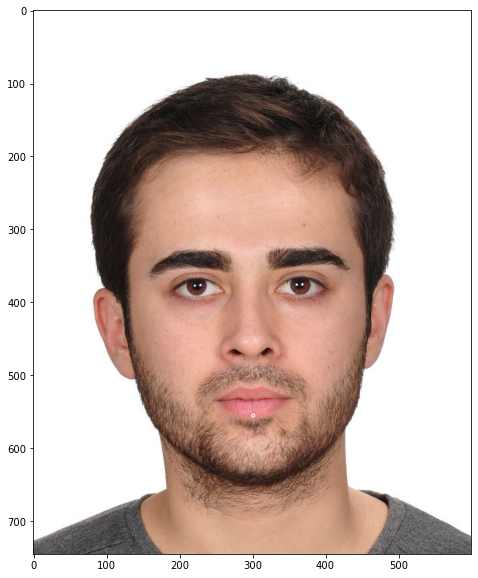

In [192]:
projection, pixel_projection, image, true = show_some_results(idx)
errors = (projection - true).reshape(-1, 2) # skutečné chyby těch dvou obrázků
#display_landmarks(projection, image, errors = None)   # případně two_std_errors
#display_landmarks(true, image)
display_landmarks(pixel_projection[2:3,:], image, pixel_scale = True, errors = None)
#idx = idx + 5

<function matplotlib.pyplot.show(close=None, block=None)>

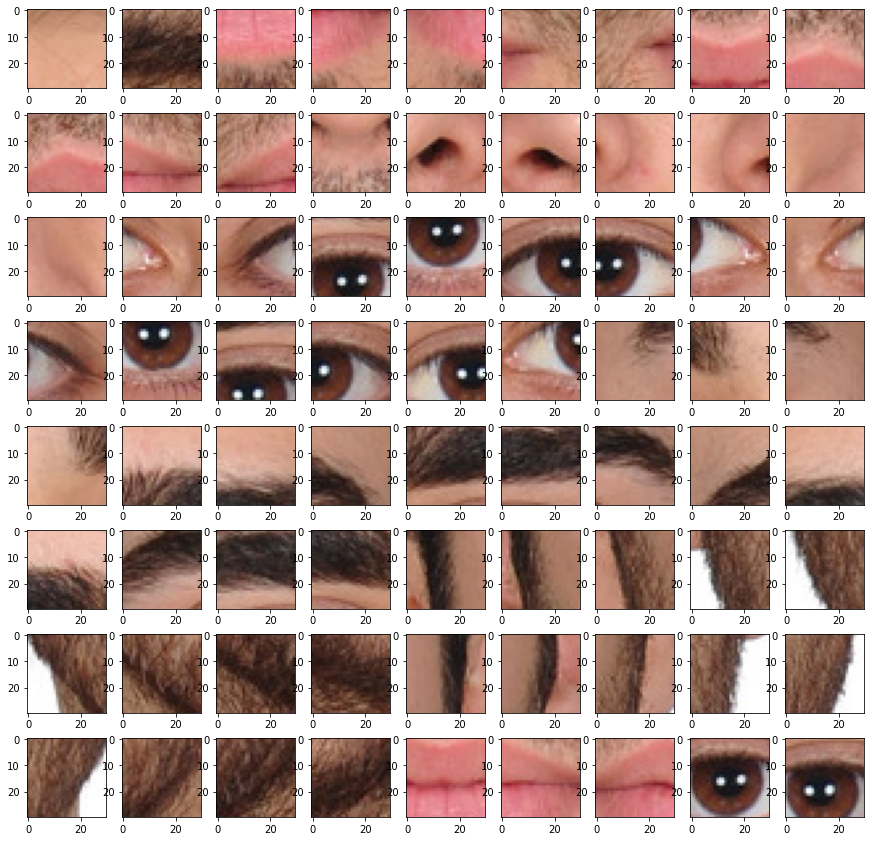

In [193]:
crop_size = 30
pixel_projection[:,1] = image.shape[0] - pixel_projection[:,1]
landmarks = torch.tensor(pixel_projection).permute(1,0)
crop_range = torch.arange(-crop_size // 2, crop_size // 2)
crop_matrix = torch.stack([crop_range.tile((crop_size,1)), crop_range[:, None].tile((1,crop_size))], dim = 2)
crop_indices = landmarks[None, None,:,:] + crop_matrix[:,:,:,None]  # dims: x_coor, y_coor, x_y, no_landmarks

sub_image = torch.tensor(image[crop_indices[:,:,1,:], crop_indices[:,:,0,:], :])
multicrop = sub_image.reshape(sub_image.shape[0], sub_image.shape[1], -1)

plt.figure(figsize = (15,15))
for i in range(landmarks.shape[1]):
    plt.subplot(8,9,i+1)
    plt.imshow(multicrop[:,:,i * 3: i * 3 + 3])

plt.show

In [ ]:
def make_landmark_crops(pixel_landmarks, image, crop_size = 30):
    
    pixel_landmarks[:,1] = image.shape[0] - pixel_landmarks[:,1]
    landmarks = torch.tensor(pixel_projection).permute(1,0)
    crop_range = torch.arange(-crop_size // 2, crop_size // 2)
    crop_matrix = torch.stack([crop_range.tile((crop_size,1)), crop_range[:, None].tile((1,crop_size))], dim = 2)
    crop_indices = landmarks[None, None,:,:] + crop_matrix[:,:,:,None]  # dims: x_coor, y_coor, x_y, no_landmarks

    sub_image = torch.tensor(image[crop_indices[:,:,1,:], crop_indices[:,:,0,:], :])
    multicrop = sub_image.reshape(sub_image.shape[0], sub_image.shape[1], -1)
    return multicrop   # shape (x, y, 3 * num_landmarks)

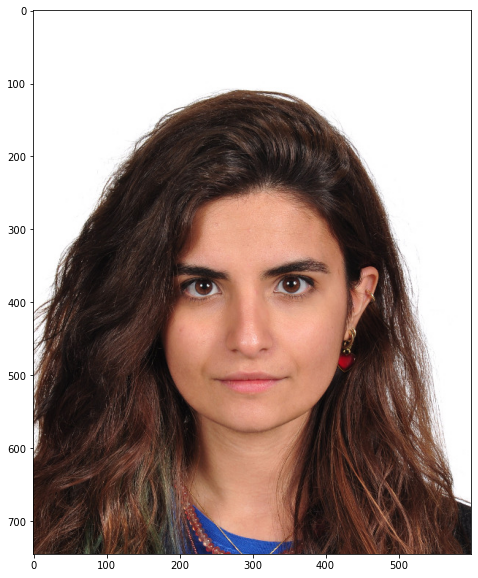

In [14]:
groups = ['Males', 'Females']
path = 'C:\\Users\\Zirov\\landmarks\\'

group = 'Females'
tps = readtps(path + group + '.TPS')
idx = 21

true_landmarks = tps['coords'][:, :, idx]
img_path = path + group + '\\' + tps['im'][idx]

image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

fig, ax = plt.subplots(1, figsize = (10,10))
ax.imshow(image)
plt.show()

In [60]:
l = MediaPipe_model(image)


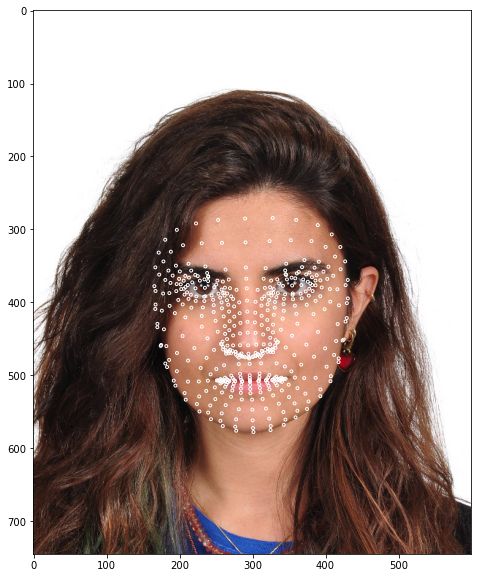

In [63]:
display_landmarks(l, image, origin = 'upper_left')

In [93]:
half_kernel = 15
# x-first
landmarks = torch.tensor([[220, 380],
                          [250, 500],
                          [430, 450]]).permute(1,0)
crop_range = torch.arange(-half_kernel, half_kernel)
crop_range = torch.stack([crop_range.tile((2 * half_kernel,1)), crop_range[:, None].tile((1,2 * half_kernel))], dim = 2)
crop_range.shape, landmarks.shape

(torch.Size([30, 30, 2]), torch.Size([2, 3]))

In [94]:
crop_idx = landmarks[None, None,:,:] + crop_range[:,:,:,None]  # dims: x_coor, y_coor, x_y, no_landmarks
crop_idx.shape

torch.Size([30, 30, 2, 3])

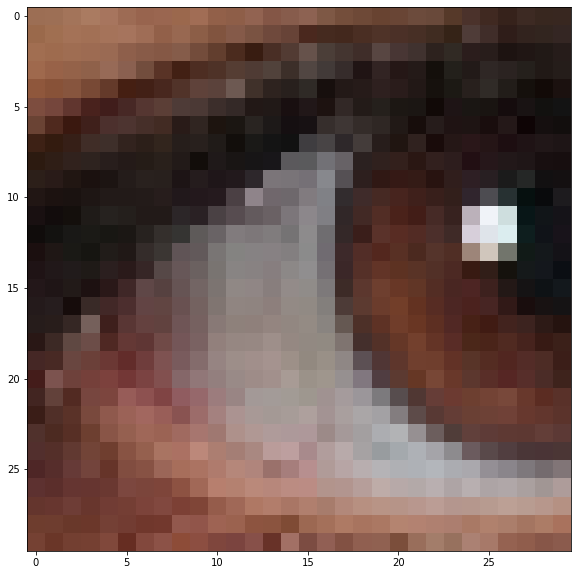

In [120]:
sub_image = torch.tensor(image[crop_idx[:,:,1,:], crop_idx[:,:,0,:], :])
multicrop = sub_image.reshape(sub_image.shape[0], sub_image.shape[1], -1)
fig, ax = plt.subplots(1, figsize = (10,10))
ax.imshow(multicrop[:,:,0:3])
plt.show()

In [54]:
sub_image.shape

(3, 30, 3)

In [ ]:
#  Co potřebuju
#  1. Nějaká funkce, která vezme obrázek a provizorní souřadnice plus rozměr patches a udělá z toho
#  tensorovou řadu obrázků, na kterou půjde udělat conv2d s groups parametrem
#  2. Práce s Dataset a Dataloader.
#         Ale jen pro landmarks nebo i pro obrázky?